In [1]:
import lstm
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import sys
import pandas as pd
from pandas import Series, DataFrame, Panel
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
import re
from datetime import datetime
from sklearn.metrics import mean_squared_error
from scipy.stats import logistic
%matplotlib inline
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 24
fig_size[1] = 18
plt.rcParams["figure.figsize"] = fig_size
keras.backend.image_dim_ordering()

Using TensorFlow backend.


Current size: [6.0, 4.0]


'tf'

In [2]:
class BatchGenerator:
    
    def __init__(self, file, time_steps, scaler_type):
        print ("Loading data ...")
        
#         print('Processing CSV :', file)
#         data_temp = fill_gaps(data, "SR", 0.05)
#         data_temp = fill_gaps(data_temp, "WD", 2.0)
#         data_temp = fill_gaps(data_temp, "WS", 0.005)
#         data_temp = fill_gaps(data_temp, "VWS", 0.005)
#         data_temp = fill_gaps(data_temp, "BP", 0.1)
#         data_temp = fill_gaps(data_temp, "TEMP", 0.05)
#         data_temp = fill_gaps(data_temp, "PM2.5", 0.05)
#         data_temp = fill_gaps(data_temp, "RH", 0.05)
        
        data_loaded = pd.read_pickle(file)
        data_loaded.isnull().sum()
        data_loaded_np = data_loaded[["PM2.5","WS","RH","BP","VWS","SR","WD","TEMP"]].as_matrix()
        
        self.time_steps = time_steps
        self.scaler_type = scaler_type
        self.X_norm_pm, self.y_norm_pm, self.scaler_pm, self.min_max_scaler_pm = self.generate_batch_data(data_loaded_np[0:,0], time_steps=self.time_steps, name="pm25")
        self.X_norm_ws, self.y_norm_ws, self.scaler_ws, self.min_max_scaler_ws = self.generate_batch_data(data_loaded_np[0:,1], time_steps=self.time_steps, name="ws")
        self.X_norm_rh, self.y_norm_rh, self.scaler_rh, self.min_max_scaler_rh = self.generate_batch_data(data_loaded_np[0:,2], time_steps=self.time_steps, name="rh")
        self.X_norm_bp, self.y_norm_bp, self.scaler_bp, self.min_max_scaler_bp = self.generate_batch_data(data_loaded_np[0:,4], time_steps=self.time_steps, name="bp")
        self.X_norm_vws, self.y_norm_vws, self.scaler_vws, self.min_max_scaler_vws = self.generate_batch_data(data_loaded_np[0:,3], time_steps=self.time_steps, name="vws")
        self.X_norm_sr, self.y_norm_sr, self.scaler_sr, self.min_max_scaler_sr = self.generate_batch_data(data_loaded_np[0:,5], time_steps=self.time_steps, name="sr")
        self.X_norm_wd, self.y_norm_wd, self.scaler_wd, self.min_max_scaler_wd = self.generate_batch_data(data_loaded_np[0:,6], time_steps=self.time_steps, name="wd")
        self.X_norm_temp, self.y_norm_temp, self.scaler_temp, self.min_max_scaler_temp = self.generate_batch_data(data_loaded_np[0:,7], time_steps=self.time_steps, name="temp")

        filename = "np_"+self.scaler_type+"_process_comp_"+str(self.time_steps)+".npz"
        if os.path.isfile("data_log/"+filename):
            print ("Found existing file :",filename)
            print ("Loading ...")
            npzfile = np.load("data_log/"+filename)
            self.X = npzfile['arr_0']
            self.Y = npzfile['arr_1']
            print ("Complete.")
        else:
            self.X = np.array(np.zeros([1, 8]))
            for i in range(len(self.X_norm_pm)):
                temp = np.column_stack((self.X_norm_pm[i],self.X_norm_ws[i],self.X_norm_rh[i],self.X_norm_bp[i],self.X_norm_vws[i],self.X_norm_sr[i],self.X_norm_wd[i],self.X_norm_temp[i]))
                self.X = np.append(self.X, temp, axis=0)

            self.X = self.X[1:].reshape(len(self.X_norm_pm),48,8)
            self.Y = self.y_norm_pm
            print ("Input shape :",np.shape(self.X))
            print ("Output shape :",np.shape(self.Y))
            print ("Saving file ...")
            np.savez("data_log/"+filename, self.X, self.Y)
            print ("Saved file to :", "data_log/"+filename)
            print ("Complete.")
        
    def return_data(self):
        return self.X, self.Y, self.scaler_pm, self.min_max_scaler_pm
    
    def fill_gaps(self, data, col, sigma):
        temp = data.copy()
        temp["FROM"][0] = "00:00:00"

        mu, sigma = 0, sigma 
        for k in range(len(temp)):
            try:
                if (str(temp[col][k]) == str(np.nan)):
                    rolling_sum = 0
                    noise = np.random.normal(mu, sigma, 1)[0]
                    rolling_sum = rolling_sum + float(temp[col][k-24]) + float(temp[col][k-48]) + float(temp[col][k-72]) + float(temp[col][k-96]) + float(temp[col][k-120]) + float(temp[col][k-144]) + float(temp[col][k-168])
                    temp[col][k] = round(1.0*rolling_sum/7 + noise,2)
            except (IndexError, ValueError):
                print ("Break at index :", k)
                break
        return temp

    def shift(self, arr, num, fill_value=np.nan):
        result = np.empty_like(arr)
        if num > 0:
            result[:num] = fill_value
            result[num:] = arr[:-num]
        elif num < 0:
            result[num:] = fill_value
            result[:num] = arr[-num:]
        else:
            result = arr
        return result

    def generate_batch_data(self, raw_data, time_steps, name):
        series = pd.Series(raw_data, dtype=np.float32)
        # prepare data for standardization
        values = series.values
        values = values.reshape((len(values), 1))

        # train the standardization
        if self.scaler_type == 'standard':
            scaler = StandardScaler()
        if self.scaler_type == 'robust':
            scaler = RobustScaler()
        if self.scaler_type == 'min_max':
            scaler = MinMaxScaler(feature_range=(0, 1))
        if self.scaler_type == 'robust_min_max':
            scaler = RobustScaler()
        if self.scaler_type == 'standard_min_max':
            scaler = StandardScaler()
            
        min_max_scaler = None    
        scaler = scaler.fit(values)
        print('feature ------------ ', name.upper())
        
        if self.scaler_type == 'standard':
            print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, math.sqrt(scaler.var_)))
            values[values > 450] = 3*scaler.mean_
            print('Data normalized... Replaced the outliers with 3 times the mean value')
        if self.scaler_type == 'robust':
            print('Data normalized... Using Robust Scaling')
        if self.scaler_type == 'min_max':
            print('Data normalized... Using Min-Max Scaling')
       
        normalized = scaler.transform(values)
        
        # min_max scaling
        if self.scaler_type == 'robust_min_max' or self.scaler_type == 'standard_min_max':
            min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
            min_max_scaler = min_max_scaler.fit(normalized)
            normalized = min_max_scaler.transform(normalized)
            if self.scaler_type == 'robust_min_max':
                print('Data normalized... Using Robust_Min-Max Scaling')
            if self.scaler_type == 'standard_min_max':
                print('Data normalized... Using Standard_Min-Max Scaling')
            
        # batch formation
        data = normalized
        print('Max: %f, Min: %f' % (np.amax(data), np.amin(data)))
        x = data[:(len(data)-(len(data) % time_steps))]
        y = self.shift(data,-(time_steps)).astype(np.float32)

        x_batches = np.array([])
        y_batches = np.array([])

        # check if file exists
        seq_file_name = "np_"+self.scaler_type+"_processed_"+name+"_"+str(time_steps)+".npz"
        if os.path.isfile("data_log/"+seq_file_name):
            npzfile = np.load("data_log/"+seq_file_name)
            x_batches = npzfile['arr_0']
            y_batches = npzfile['arr_1']
            return x_batches, y_batches, scaler, min_max_scaler
        else: 
            for i in range(len(y)):
                try:
                    x_batches = np.append(x_batches, x[i:i+time_steps].reshape(-1,12,1))
                    y_batches = np.append(y_batches, y[i].reshape(-1))
                except ValueError:
                    break
            x_batches = x_batches.reshape(-1, time_steps, 1)
            y_batches = y_batches.reshape(-1)
            np.savez("data_log/"+seq_file_name, x_batches, y_batches)
            return x_batches, y_batches, scaler, min_max_scaler

In [3]:
if __name__=='__main__':
    epochs  = 150
    state_neurons_1 = 256
    seed = 7
    batch_size = 32
    scaler_type="min_max"
    dropouts = [0.05, 0.14, 0.35]
    seq_len = 48
    file_name = "wt_LSTM_Keras_multi_adam_autoen_imp2_"+scaler_type+"_dp("+"_".join(str(x) for x in dropouts)+")_"+str(epochs)+"_"+str(seq_len)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(batch_size)
    
    batch_generator_obj = BatchGenerator(file="data_log/mumbai_6_log_pro.pkl", time_steps=seq_len, scaler_type=scaler_type)
    X_norm, y_norm, scaler, min_max_scaler = batch_generator_obj.return_data()
    X_train, X_val, y_train, y_val = train_test_split(X_norm, y_norm, test_size=0.20, random_state=seed)
    
    #recreate model 
    model = lstm.build_model([4, 8], [8, seq_len, state_neurons_1, 1, state_neurons_1], dropouts, pre_train=file_name+".h5")
   
    
    print("Created model and loaded weights from "+file_name+".h5")
    
    # estimate accuracy on whole dataset using loaded weights
    _y_val = lstm.predict_point_by_point(model, X_val)
#     _y_test = lstm.predict_point_by_point_aux(model,  [X_test, X_aux_test])
    
    _y_val = _y_val.reshape(-1,1)
#     _y_test = _y_test.reshape(-1,1)
    
    y_val = y_val.reshape(-1,1)
#     y_test = y_test.reshape(-1,1)
    
    #inverse the predictions to its actual value
    print("Predicted Output sample: ")
    _y_va = scaler.inverse_transform(_y_val)
#     _y_te = scaler.inverse_transform(_y_test)
    for i in range(5):
        print(_y_va[i])
    
    #inverse the outputs to its actual value
    print("Original Output sample: ")
    y_va = scaler.inverse_transform(y_val)
#     y_te = scaler.inverse_transform(y_test)
    for i in range(5):
        print(y_va[i])    
    
    
    y_va = np.exp(y_va)
    _y_va = np.exp(_y_va)
    
    
    #predicted
    _Y_VA = pd.Series(np.ravel(_y_va))
#     _Y_TE = pd.Series(np.ravel(_y_te))
    
    #original
    Y_VA = pd.Series(np.ravel(y_va))
#     Y_TE = pd.Series(np.ravel(y_te))

Loading data ...
feature ------------  PM25
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  WS
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  RH
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  BP
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  VWS
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  SR
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  WD
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
feature ------------  TEMP
Data normalized... Using Min-Max Scaling
Max: 1.000000, Min: 0.000000
Found existing file : np_min_max_process_comp_48.npz
Loading ...
Complete.
> Compilation Time :  0.033086299896240234
Created model and loaded weights from wt_LSTM_Keras_multi_adam_autoen_imp2_min_max_dp(0.05_0.14_0.35

Validation RMSE : 17.735902882051523


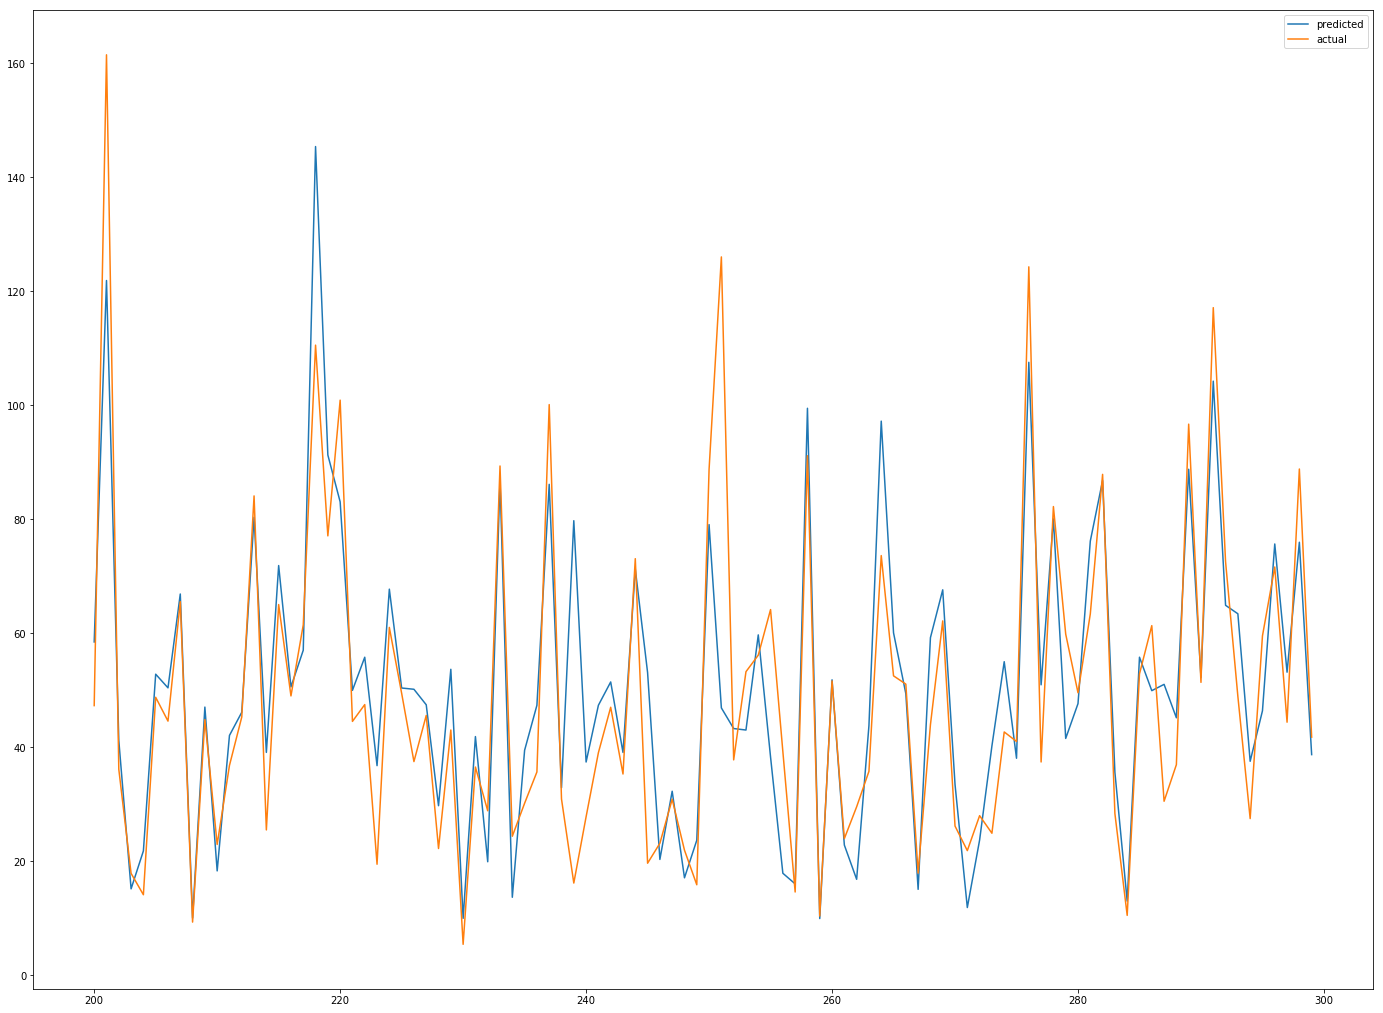

In [4]:
if __name__=='__main__':
    print('Validation RMSE :', math.sqrt(mean_squared_error(_Y_VA, Y_VA)))
    plot_predicted, = plt.plot(_Y_VA[200:300], label='predicted')
    plot_train, = plt.plot(Y_VA[200:300], label='actual')
    plt.legend(handles=[plot_predicted, plot_train])